In [1]:
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2  # will autoreload all packages imported with %aimport

In [2]:
%reload_ext autoreload
%autoreload 2 

import numpy as np
import pandas as pd
import os
import matplotlib
from matplotlib import pyplot as plt
from pickle import load as pload
from json import load as load_json

sys.path.insert(1, os.path.join(sys.path[0], '..'))  # for importing local packages from src

from src.model.hydroshoot_experiment import load_runs, HydroShootExperiment

## Loading experiment data

In [3]:
EXPERIMENT_ROOT = 'F:/thesis-cyborg-plants/results/fixed_predawn_7days_jun_jul_aug'
assert(os.path.isdir(EXPERIMENT_ROOT))

In [4]:
# Loading all the data
runs = load_runs(EXPERIMENT_ROOT)
print(len(runs))

84


In [5]:
print('Targets:', runs[0].get_targets())
print('Variables:', runs[0].get_state_variables())


Targets: ('input_Tac', 'input_u', 'input_hs', 'input_Rg', 'output_Rg', 'output_An', 'output_E', 'output_Tleaf')
Variables: ('Ci', 'gb', 'Ei', 'FluxC', 'Tlc', 'An', 'Flux', 'psi_head', 'u', 'E', 'Eabs', 'gs', 'par_photo.dHd')


## Preprocess data for learning

In [6]:
runs[0].n_steps()

168

In [7]:
from src.learning.preprocessing import preprocess_data, reshape_data, generate_mask

STATE_VAR = 'Tlc'
TARGET = 'output_Rg'
STATE_SIZE = 64
SAMPLES_PER_RUN = 2
WARMUP_STEPS = 24
DAYLIGHT_MASK = generate_mask(5, 21)

X, y = preprocess_data(runs, STATE_VAR, TARGET,
    state_size=STATE_SIZE,
    samples_per_run=SAMPLES_PER_RUN,
    warmup_steps=WARMUP_STEPS,
    mask=DAYLIGHT_MASK,
)

print(X.shape, y.shape)

(84, 2, 6, 16, 64) (84, 2, 6, 16)


In [8]:
from src.learning.grouping import alternating_groups
from scipy.stats import zscore


N_CV_GROUPS = 2

X_train, y_train = reshape_data(X, y)
groups = alternating_groups(X, n_groups=N_CV_GROUPS)

y_train = zscore(y_train)


print(X_train.shape, y_train.shape, groups.shape)

(16128, 64) (16128,) (16128,)


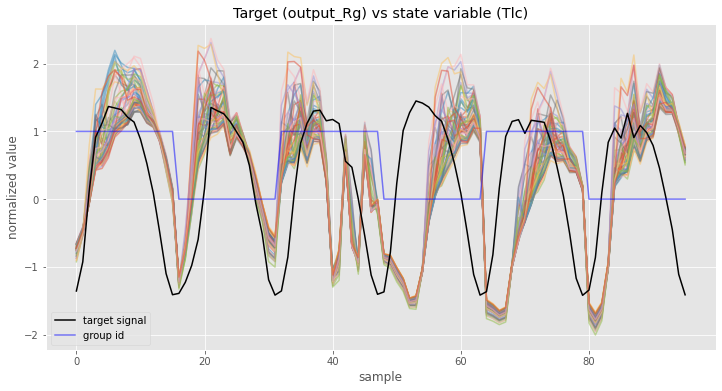

In [9]:
size = 16
point = 2000

with plt.style.context('ggplot'):
  plt.figure(figsize=(12, 6))
  plt.plot(X_train[point:point + 6 * size], alpha=0.5)
  plt.plot(y_train[point:point + 6 * size], c='black', label='target signal')
  plt.plot(groups[point:point + 6 * size], c='blue', alpha=0.5, label="group id")
  plt.title(f'Target ({TARGET}) vs state variable ({STATE_VAR})')
  plt.xlabel('sample')
  plt.ylabel('normalized value')
  plt.legend()
  plt.show()

## Training readout functions

In [10]:
from sklearn.model_selection import LeaveOneGroupOut
folds = LeaveOneGroupOut()

In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from src.learning.scorers import nmse_scorer
from util import print_cv_scores, print_search_scores, print_search_best_params

readout = Pipeline([
    ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

cv_scores = cross_validate(readout, X_train, y_train, 
    groups=groups, 
    cv=folds, 
    scoring=nmse_scorer, 
    return_train_score=True, 
    n_jobs=-1, 
    verbose=False)

print('--- Untuned score ---')
print_cv_scores(cv_scores)


--- Untuned score ---
  - Train: -0.8385 +/- 0.02032
  - CV:    -0.8529 +/- 0.01975


In [12]:
search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e6), 500)

}]

grid_search = GridSearchCV(readout, 
  param_grid=search_grid, 
  cv=folds, 
  scoring=nmse_scorer, 
  n_jobs=-1, 
  verbose=False, 
  return_train_score=True
  )

grid_search.fit(X_train, y_train, groups=groups)

print('\n\n--- Tuned hyperparemeters ---')
print_search_best_params(grid_search)
print_search_scores(grid_search)



--- Tuned hyperparemeters ---
  - ridge_regression__alpha = 81.6250851428722
  - Train: -0.8393 +/- 0.02047
  - CV:    -0.8520 +/- 0.02101


In [53]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(max_iter=1600, verbose=True)

mlp.fit(X_train, y_train)

Iteration 1, loss = 44021.28169925
Iteration 2, loss = 40344.40098233
Iteration 3, loss = 34872.17595644
Iteration 4, loss = 28493.60236392
Iteration 5, loss = 23205.18261082
Iteration 6, loss = 20403.23894755
Iteration 7, loss = 19626.51219524
Iteration 8, loss = 19517.25223599
Iteration 9, loss = 19485.05781897
Iteration 10, loss = 19451.07770093
Iteration 11, loss = 19418.57698085
Iteration 12, loss = 19379.31233901
Iteration 13, loss = 19336.09318259
Iteration 14, loss = 19292.29267832
Iteration 15, loss = 19243.07662803
Iteration 16, loss = 19186.86408414
Iteration 17, loss = 19124.04063171
Iteration 18, loss = 19050.66006631
Iteration 19, loss = 18970.38909808
Iteration 20, loss = 18884.11603275
Iteration 21, loss = 18786.48076569
Iteration 22, loss = 18682.98733630
Iteration 23, loss = 18582.21151245
Iteration 24, loss = 18460.10193699
Iteration 25, loss = 18346.50457665
Iteration 26, loss = 18234.51137515
Iteration 27, loss = 18090.09768507
Iteration 28, loss = 17946.35182400
I

MLPRegressor(max_iter=1600, verbose=True)

In [55]:
nmse_scorer(mlp, X_train, y_train)

-0.6808404537357257

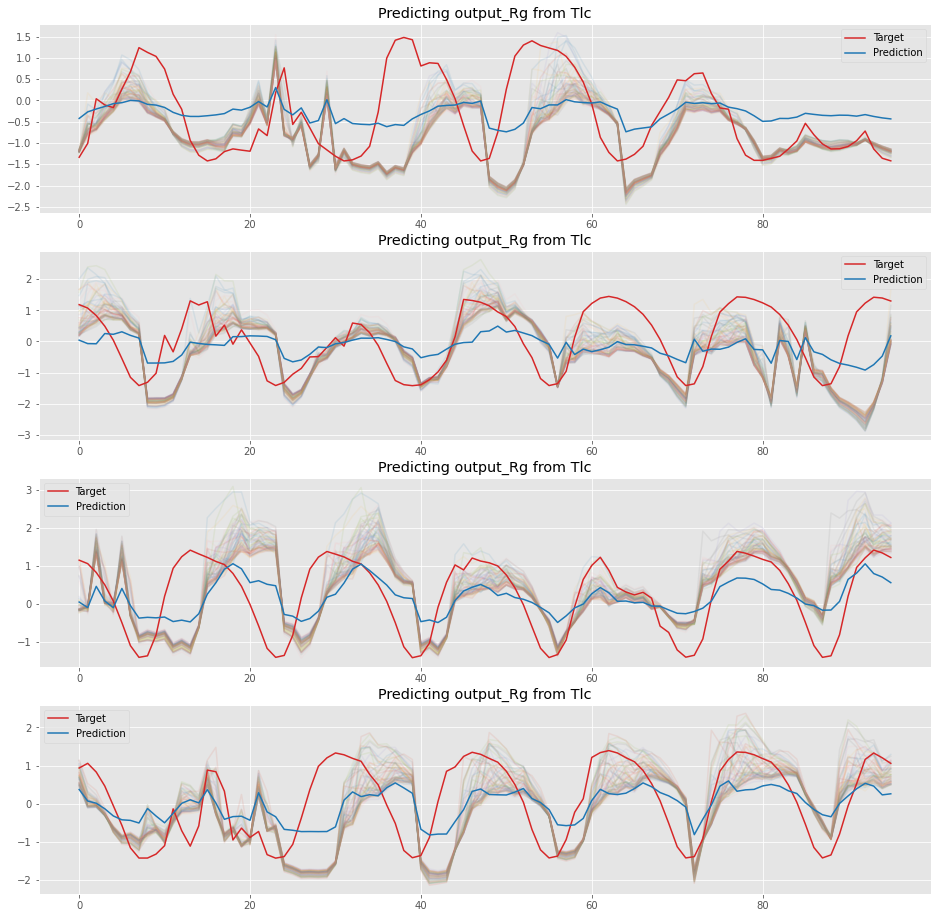

In [14]:
# visualize fit

points = [0, 1000, 3000, 5000]

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(4, 1, figsize=(16, 16))

  for i, p in enumerate(points):
    # state_idx = np.random.choice(run.state_size(), STATE_SIZE, replace=False)
    X_ = X_train[p:p + 16 * 6] # run.states[STATE_VAR][WARMUP_STEPS:, state_idx]

    target = y_train[p:p + 16 * 6] # run.outputs[TARGET][WARMUP_STEPS:].to_numpy()
    y_pred = grid_search.predict(X_)

    for j in range(STATE_SIZE):
      ax[i].plot(X_[:, j], alpha=0.1)

    ax[i].plot(target, label='Target', c='tab:red')
    ax[i].plot(y_pred, label='Prediction', c='tab:blue')
    ax[i].set_title(f'Predicting {TARGET} from {STATE_VAR}')
    ax[i].legend()

  plt.show()

In [87]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()

Loading BokehJS ...

In [126]:
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error


start, end = 1000, 2000

p = figure(plot_width=900, plot_height=500, title=f'Predicting {TARGET} from {STATE_VAR}', x_range=(start, start + 96))

X_ = X_train[start:end]
target = y_train[start:end]
y_pred = grid_search.predict(X_)

# z_target = zscore(target)
# z_y_pred = zscore(y_pred)

# loss = mean_squared_error(target, y_pred) # / (target.var() + 1e-12)
# z_loss = mean_squared_error(z_target, z_y_pred) # / (z_target.var() + 1e-12)

# print(loss)
# print(z_loss)


p.line(np.arange(start, end), target, color='orangered', width=2, legend_label='Target')
p.line(np.arange(start, end), y_pred, color='royalblue', width=2, legend_label='Prediction')

show(p)